# Find Stamps with Single Antenna High Power Signals

Noah Stiegler

7/9/2024

Some of the hits with stamp files are due to a single antenna recording a very strong signal which looks like a technosignature. However, because all the antennas are pointed in the same direction on the sky, this means the signal isn't from an extraterrestrial technosignature, but rather RFI (radio frequency interference) from near the antenna itself. In this notebook, I'm going to explore different ways of finding these anomalous signals so we can weed them out of the dataset

### Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import regular packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

In [3]:
# Next we'll import the seticore viewer package: 
# Unfortunately, it can be a little fiddley
# I'm using the Python 3.7 (base) conda environment on blpc1 
# I was having issues with the Python 3.9 seticore_viewer conda environment I created on blpc1
# The standard maintained branch is https://github.com/MydonSolutions/seticore
# although I added some additional functionality on my own fork at https://github.com/NMStiegler/seticore
# so if my plots look different that's why
# These packages may need to be pip installed if they're not already
try:
    from seticore import viewer
except:
    # May need to install pycapnp
    try:
        %pip install pycapnp
    except:
        %conda install pycapnp
    # %pip install "git+https://github.com/NMStiegler/seticore#egg=seticore&subdirectory=python"
    %pip install pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
    from seticore import viewer

In [4]:
# Define where the data is

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1":
    DATA_PATH = "/datax/scratch/nstieg/"
    # Define which data you want to look at
    BFR_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.bfr5"
    STAMPS_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps"
else:
    raise Exception("Data path not known")

In [5]:
# Load in the stamps (with recipes in bfr5 file with the same name in the same location)
# and make sure they all got read in correctly
stamps_gen = viewer.read_stamps(STAMPS_PATH, find_recipe=True)
stamps = []
for stamp in stamps_gen:
    stamps.append(stamp)
    assert(stamp != None)
    assert(stamp.recipe != None)

print("Found:", len(stamps), "stamps")

Found: 49 stamps


/home/nstieg/.local/lib/python3.7/site-packages/seticore/viewer.py:125: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(filepath)


### Look at statistics on antenna data from a stamp file

In [6]:
# Test on a single stamp first
stamp = stamps[0]

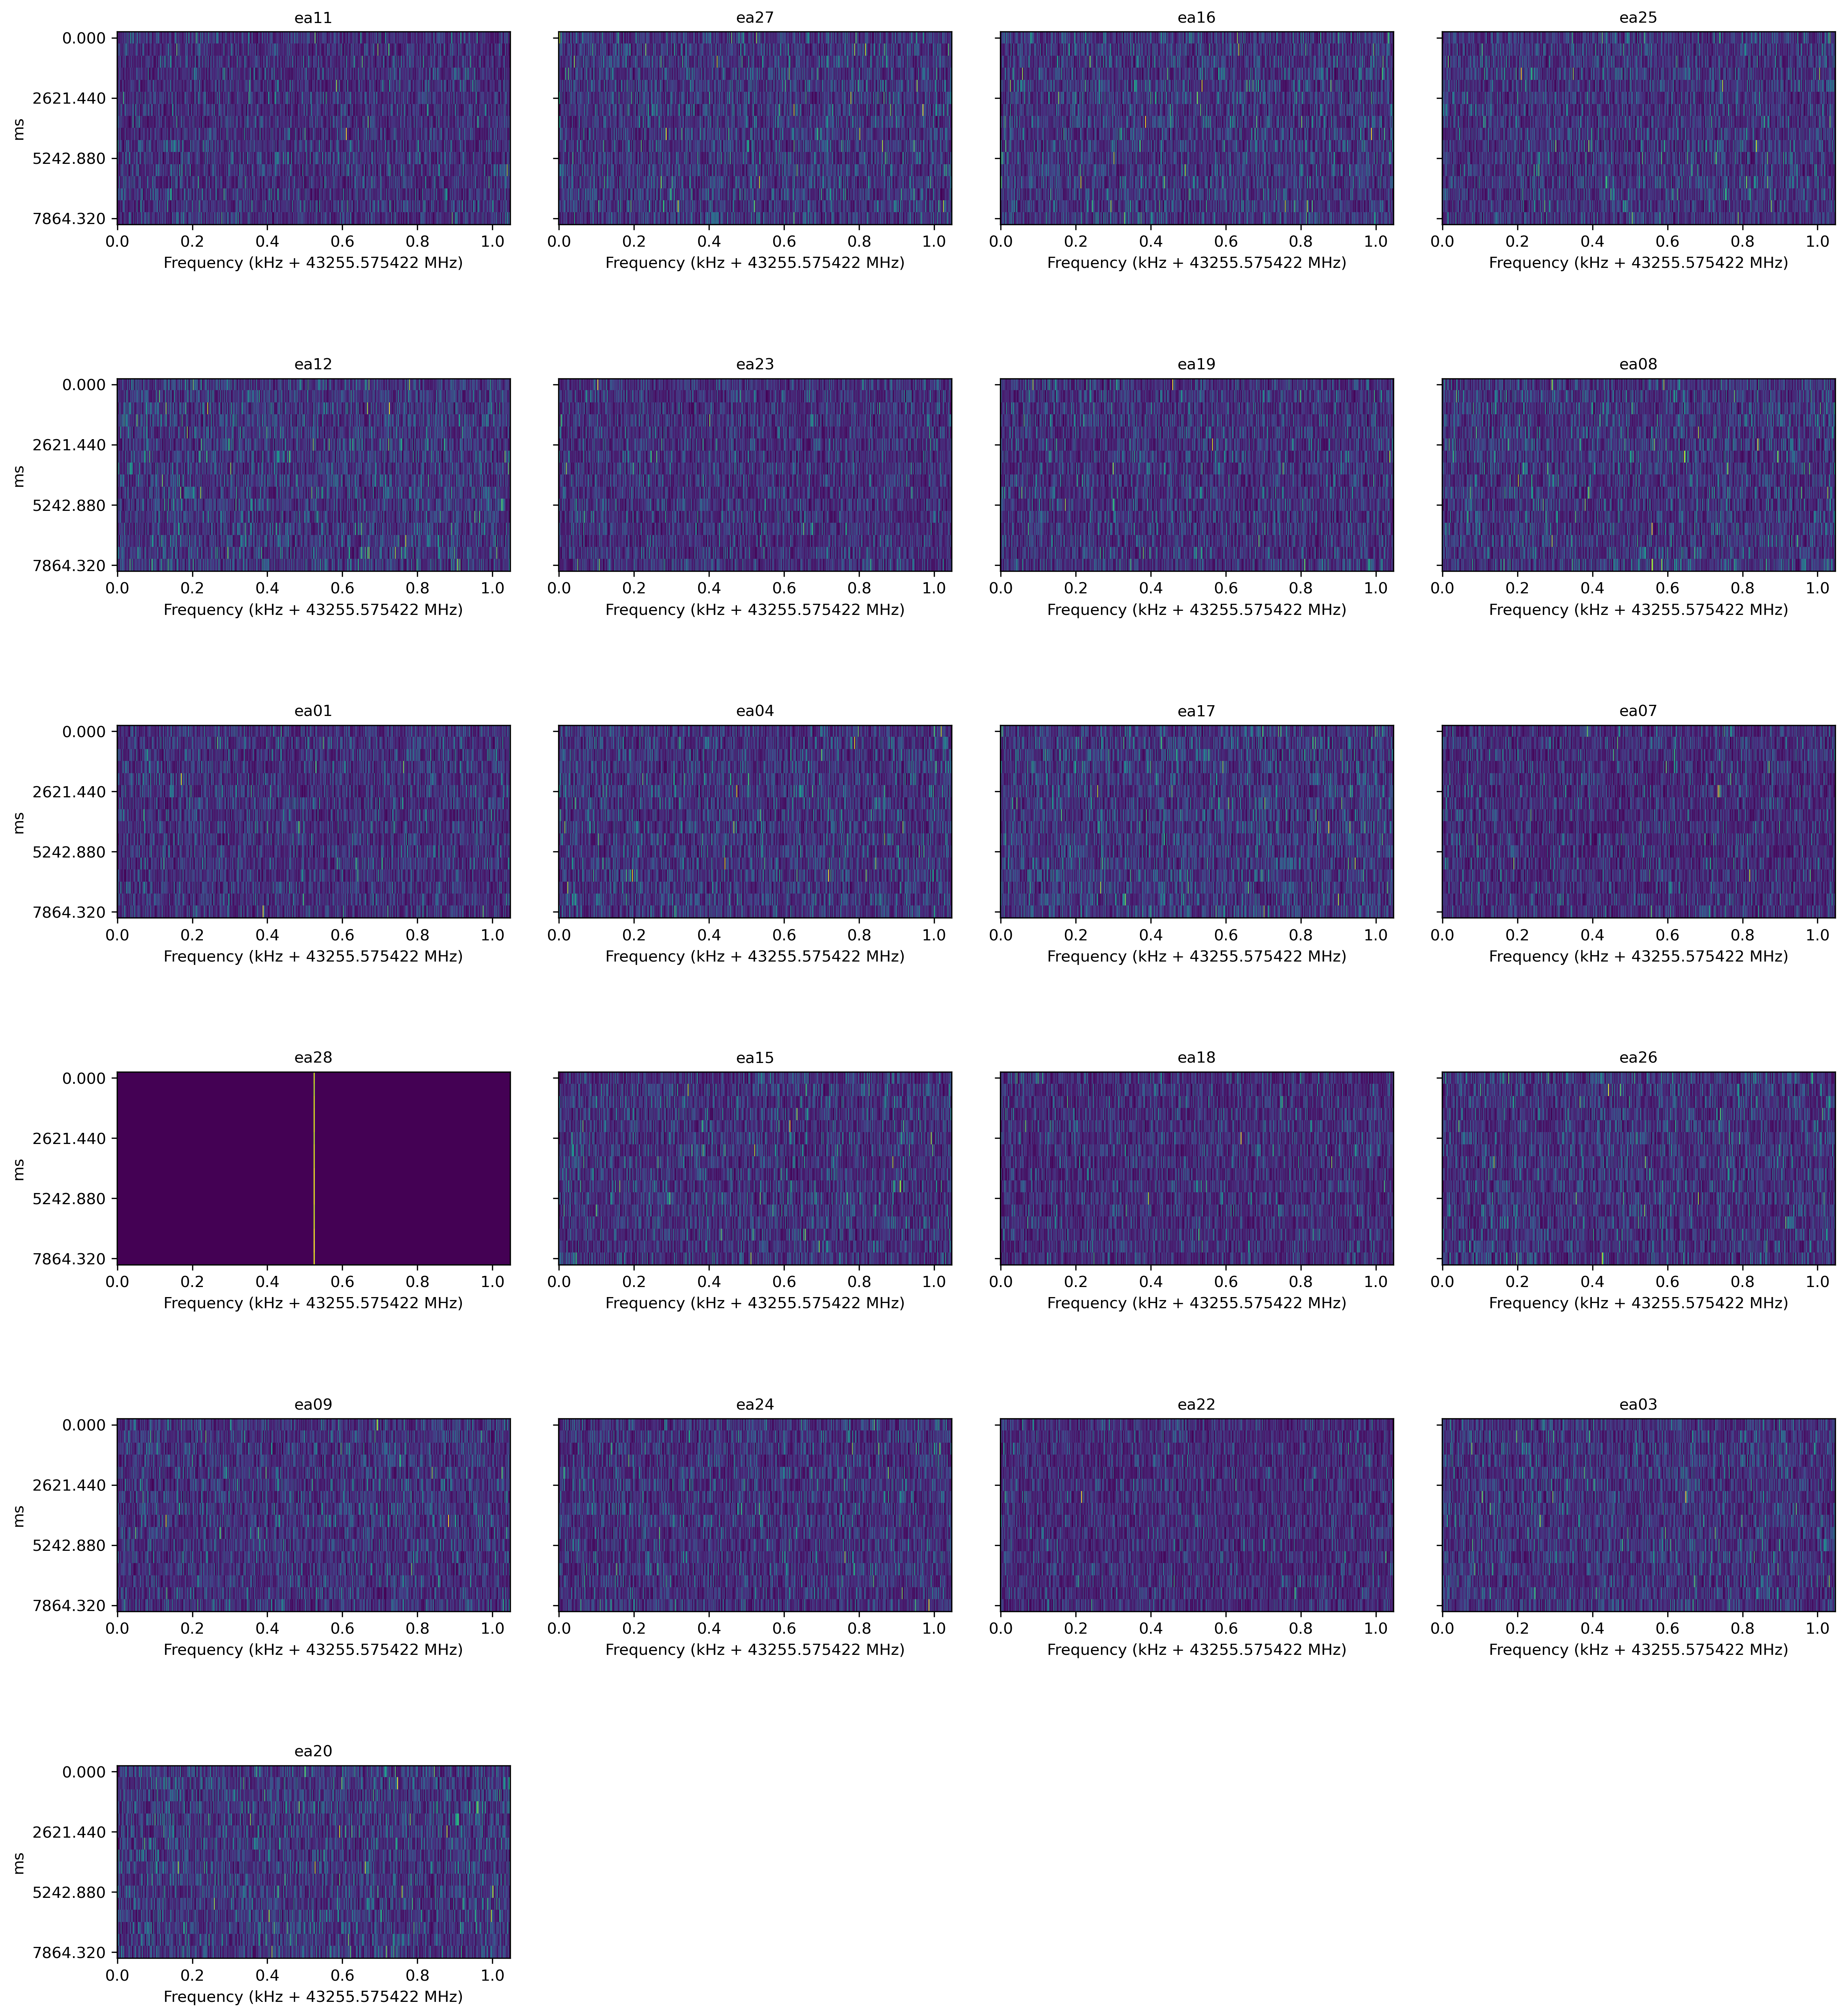

recalculated power: 1.077192e+14
local SNR: 13837.185084537112


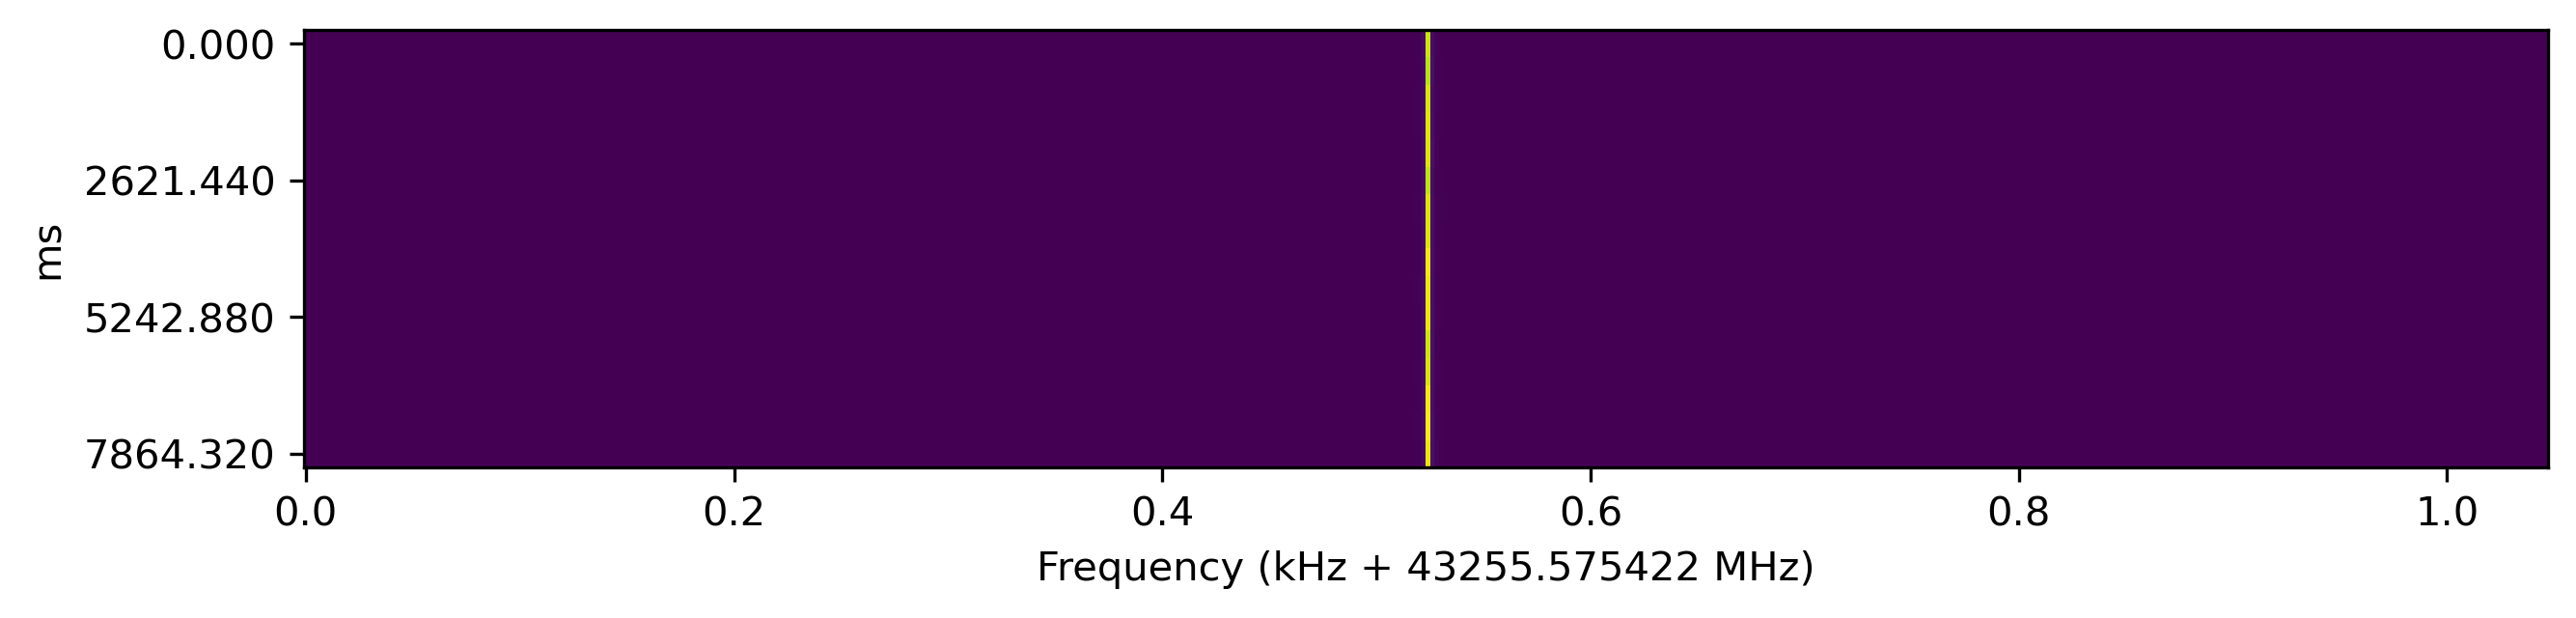

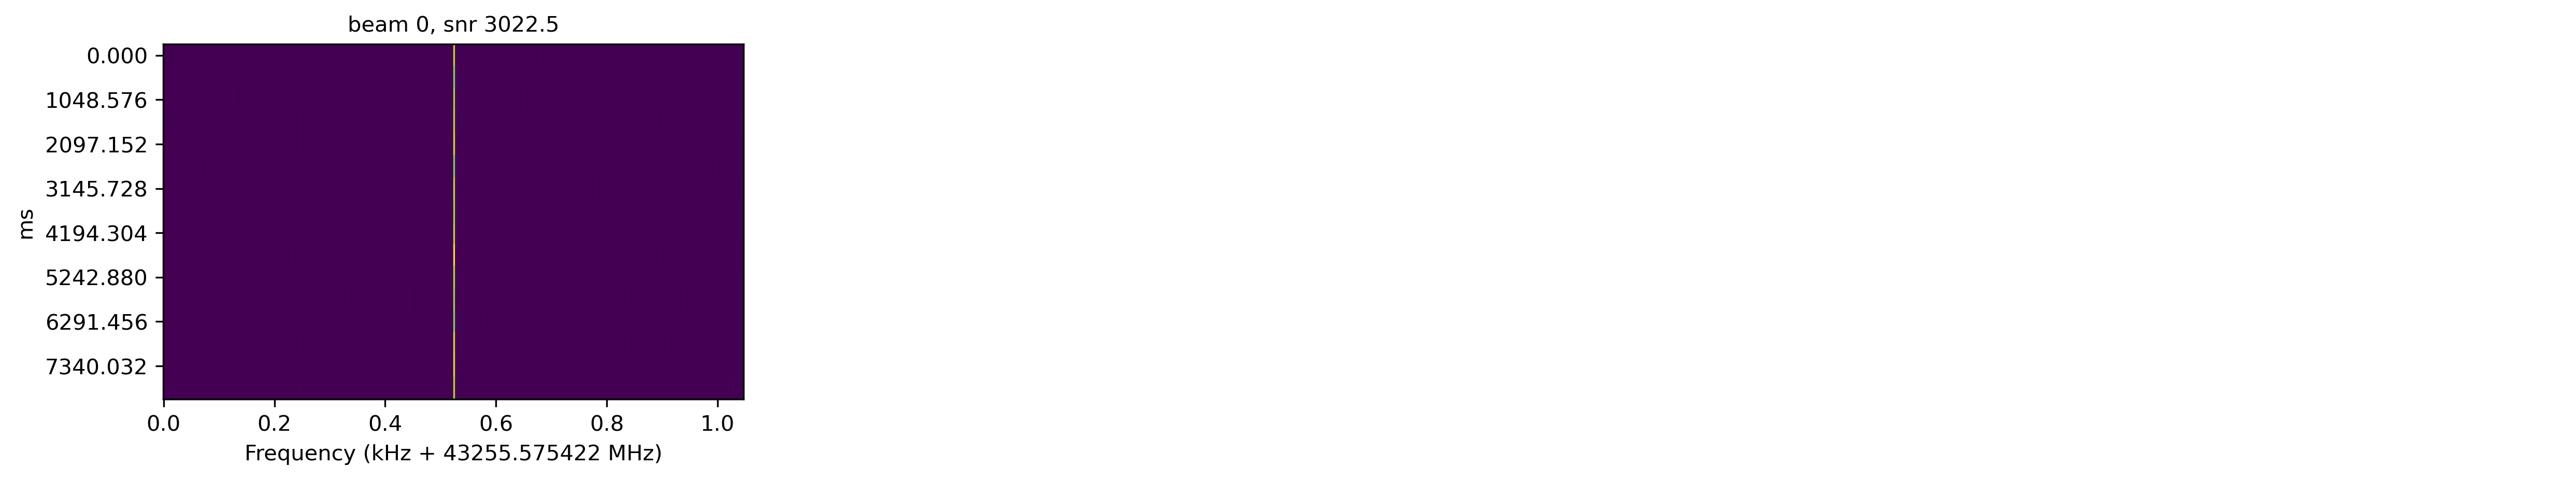

In [7]:
# Look at the stamp, note how a single antenna is at a way higher power, causing the signal
def look_at_stamp(stamp, title=None, show_signal=False):
    stamp.show_antennas(title=title, show_signal=show_signal)
    stamp.show_classic_incoherent(title=title, show_signal=show_signal)
    stamp.show_beams(title=title, show_signal=show_signal)

look_at_stamp(stamp)

In [8]:
# Figure out what's in this real array
stamp.real_array().shape
# 16 timesteps (index 0)
# 524 channels? (index 1)
# 2 polariations? (index 2)
# 21 antennas (index 3)
# 2 components of a complex number, 0 is I, 1 is Q

(16, 524, 2, 21, 2)

In [9]:
# So get the actual antenna incoherent power (power squared)
# by taking something like P^2 ~= (right circular polarization)^2 + (left circular polarization)^2
# and also that P^2 ~= (real component)^2 + (imaginary component)^2
# because we have a complex number (real and imaginary component) to describe what's received by each polarization?
antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4))
print(antenna_powers.shape)

(16, 524, 21)


In [10]:
# So now we want to look at the statistics for each antenna and also then the 
# antenna array to see if we can find an obvious outlier
medians = np.median(antenna_powers, axis=(0, 1))
maxes = np.max(antenna_powers, axis=(0, 1))
mins = np.min(antenna_powers, axis=(0, 1))
means = np.mean(antenna_powers, axis=(0, 1))

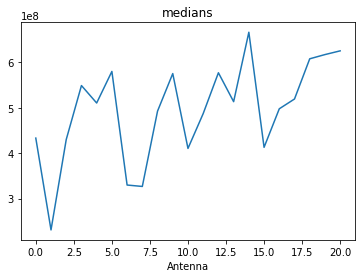

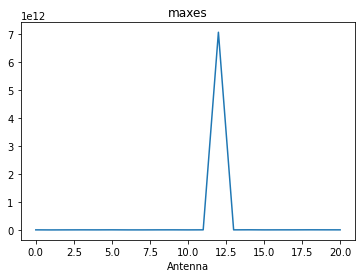

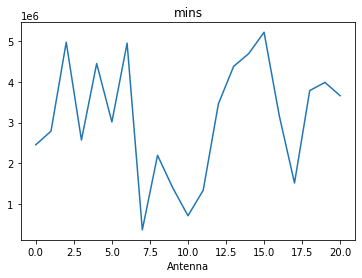

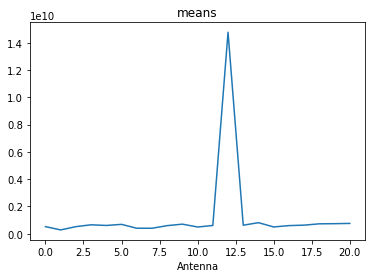

In [11]:
for stat, name in [(medians, "medians"), (maxes, "maxes"), (mins, "mins"), (means, "means")]:
    plt.plot(range(len(stat)), stat)
    plt.title(name)
    plt.xlabel("Antenna")
    plt.show()

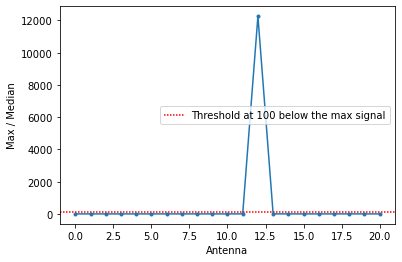

In [23]:
plt.plot(range(21), maxes / medians, marker='.')
antenna_signal_threshold = 100
plt.axhline(max(maxes / medians) / antenna_signal_threshold, c='r', dashes=[1, 1, 1, 1], label=f"Threshold at {antenna_signal_threshold}x below the max signal")
plt.ylabel("Max / Median")
plt.xlabel("Antenna")
plt.legend()
plt.show()

In [13]:
max_median_ratio = maxes / medians
print(max_median_ratio)
max_of_max_median_ratio = max(max_median_ratio)
print(max_of_max_median_ratio)
print(max_median_ratio >= max_of_max_median_ratio / 100)
num_above_100x_threshold = sum(max_median_ratio >= max_of_max_median_ratio / 100)
print(num_above_100x_threshold)

[8.07055153e+00 6.96493258e+00 7.01447588e+00 7.28142545e+00
 6.67869917e+00 7.88626887e+00 7.74602481e+00 7.26417755e+00
 7.89683212e+00 7.39135971e+00 6.85445102e+00 8.84815668e+00
 1.22573194e+04 7.67315462e+00 8.66395917e+00 7.49744239e+00
 7.49043355e+00 7.86616324e+00 8.89169317e+00 7.41773553e+00
 6.81375054e+00]
12257.31942005083
[False False False False False False False False False False False False
  True False False False False False False False False]
1


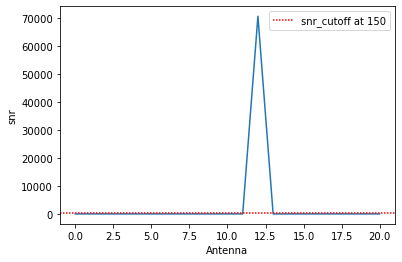

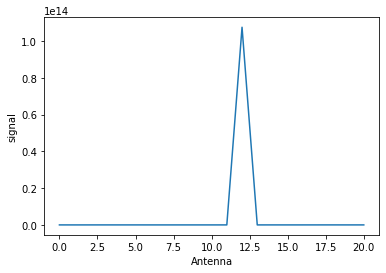

In [18]:
rearranged_antenna_powers = antenna_powers.transpose(2, 0, 1)
snr_and_signals = pd.DataFrame(np.array([stamp.snr_and_signal(antenna_power) for antenna_power in rearranged_antenna_powers]), 
                                   columns=["snr", "signal"])

plt.plot(range(len(snr_and_signals)), snr_and_signals["snr"])
snr_cutoff = 150
plt.axhline(snr_cutoff, label=f"snr_cutoff at {snr_cutoff}", dashes=[1, 1, 1, 1], c='r')
plt.xlabel("Antenna")
plt.ylabel("snr")
plt.legend()
plt.show()

plt.plot(range(len(snr_and_signals)), snr_and_signals["signal"])
plt.xlabel("Antenna")
plt.ylabel("signal")
plt.show()

In [41]:
# Given a stamp file, will check if there's a single
# antenna which is creating most of the signal observed
# Parameters:
# stamp - the stamp object
# snr - the signal to noise ratio above which there's deemed a signal
#       in the antenna. If None, doesn't check for this
# threshold - If a signal in a single antenna (or n_anomalous_antennas) is this much higher
#             than the signals in all other antennas, it's deemed anomalous
#             For example, if the powers of five anennas are [1, 4, 7, 10_000, 15]
#             then antenna 3 would be anomalous for a threshold of 10_000/15 (666.66...) or lower
# n_anomalous_antennas - The maximum number of antennas to look for interference in. Should be somewhere
#             between 1 (corresponding to looking for RFI in just one antenna, if there's RFI above the 
#             threshold in 2 antennas it won't count) and (the total number of antennas used - 1) 
#             which would be looking for RFI in all but one of the antennas (only if there's a signal above
#             the threshold in all antennas will the signal be deemed non-RFI)
# Returns:
# (indices_of_anomalous_antennas, threshold_of_detection) 
# indices_of_anomalous_antennas - a list of the anomalous antennas or an empty list if no
# anomalous signals are detected
# threshold_of_detection - The ratio between the maximum signal detected and the maximum signal 
#                          below the threshold or None if there are no signals above the snr cutoff in any antenna
def find_anomalous_antennas(stamp, threshold, snr=None, n_anomalous_antennas=1):
    assert(threshold >= 1) # Threshold only makes sense if it's 1 or greater
    assert(stamp != None)
    assert(snr == None or isinstance(snr, (int, float))): # snr should be None or an int or a float
    
    # Get the powers in the frequency bins of each antenna by summing 
    # over polarization and complex magnitude
    # Also rearrange so indices are (antenna, time bin, frequency bin)
    antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4)).transpose(2, 0, 1)
    assert(n_anomalous_antennas >= 1 and n_anomalous_antennas < len(antenna_powers)) # Look for [1, n_antennas - 1] anomalous antennas

    # Find the power and snr of each antenna
    snr_and_signals = pd.DataFrame(np.array([stamp.snr_and_signal(antenna_power) for antenna_power in antenna_powers]), 
                                   columns=["snr", "signal"])
    
    # Check the snr constraint if there is one
    if (snr != None):
        candidates_for_max = snr_and_signals["snr"] >= snr
        # Check if there's nothing we'd call a signal
        if candidates_for_max.sum() < 1:
            return ([], None) # No signals in any antenna
        index_of_max = snr_and_signals[candidates_for_max]["signal"].idxmax()
    else:
        index_of_max = snr_and_signals["signal"].idxmax()
    
    # Check how many signals are threshold times larger than the maximum
    maximum = snr_and_signals["signal"][index_of_max]
    indices_above_threshold = np.where(snr_and_signals["signal"] * threshold > maximum)[0]
    number_above_threshold = len(indices_above_threshold) # At least 1 because maximum * threshold > maximum (threshold >= 1)

    # If we see anomalies in the number of anomalous antennas we're looking for or fewer
    # (ie looking for 3 or fewer anomalous antennas and we see anomalously high signals
    # in two antennas) then deem it anomalous RFI, otherwise it's a normal signal which
    # was detected in multiple antennas
    if number_above_threshold <= n_anomalous_antennas:
        max_under_threshold = max(snr_and_signals["signal"][snr_and_signals["signal"] * threshold <= maximum])
        threshold_of_detection = maximum / max_under_threshold
        return (indices_above_threshold, threshold_of_detection)
    else:
        return ([], threshold_of_detection)

find_anomalous_antennas(stamps[0], 100, snr=999)

SyntaxError: invalid syntax (<ipython-input-41-aa14941fbe8b>, line 25)

In [ ]:
# Try the function on the stamp file with a reasonable and super high threshold
# to see if it correctly finds the anomalous antenna or no signals which match the pattern
print(find_anomalous_antennas(stamps[0], 100, snr=999))
print(find_anomalous_antennas(stamps[0], 100000000, snr=999))

AssertionError: 

In [ ]:
# Look for anomalous anennas in all the stamps in the stamp file
threshold = 100
anomalies = [] # push (stamp, antenna) for anomalies
for i, stamp in enumerate(stamps):
    indices_of_anomalous_antennas, threshold_of_detection = find_anomalous_antennas(stamp, threshold, snr=8)
    if len(indices_of_anomalous_antennas) > 0:
        print(f"Stamps {i} has single-antenna RFI on antenna(s) {indices_of_anomalous_antennas} with a threshold of {threshold_of_detection} above signals in other antennas")
        anomalies.append((i, indices_of_anomalous_antennas))

Stamp 0 has single-antenna RFI on antenna 12 with a threshold of 100 above signals in other antennas
Stamp 1 has single-antenna RFI on antenna 20 with a threshold of 100 above signals in other antennas
Stamp 2 has single-antenna RFI on antenna 13 with a threshold of 100 above signals in other antennas
Stamp 3 has single-antenna RFI on antenna 11 with a threshold of 100 above signals in other antennas
Stamp 4 has single-antenna RFI on antenna 15 with a threshold of 100 above signals in other antennas
Stamp 5 has single-antenna RFI on antenna 7 with a threshold of 100 above signals in other antennas
Stamp 6 has single-antenna RFI on antenna 10 with a threshold of 100 above signals in other antennas
Stamp 7 has single-antenna RFI on antenna 5 with a threshold of 100 above signals in other antennas
Stamp 8 has single-antenna RFI on antenna 9 with a threshold of 100 above signals in other antennas
Stamp 9 has single-antenna RFI on antenna 8 with a threshold of 100 above signals in other ant